# Creating an NLP Neural Network to Predict Category of Wine & Discover Unique Keywords

Flatiron School - Cohort 100719PT

Instructor - James Irving

By Acusio Bivona

## Introduction: For this project, I will be using a deep NLP network and a random forest model on a dataset consisting of professional wine reviews in an attempt to try and determine if specific keywords are affiliated with cheap or expensive wine. One important thing to note is that the price point for cheap vs. expensive wine was arbitrarily chosen based on the distribution of the data. 

> If such results are determined, then I believe a use case for these results would be that a winery can use the specific keywords in their marketing efforts to both portray a 'fancier' feel to cheap wines, as well as provide a 'friendlier' feel to expensive wines. I also believe that wineries can take these keywords and use them in wine production, such as finding unique flavors and aromas for each group and experimenting with their recipes to provide different products that can be more appealing to more groups. 

# Obtain and investigate data

In [1]:
import pandas as pd
df = pd.read_csv("winemag-data-130k-v2.csv")
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [5]:
def fill_cols_na(df, column):
    
    """This function can be used to fill in columns with a literal 'N/A', if it is necessary
    
    Parameters:
    
    df - dataframe to pull columns from
    
    column - can be a single column or list of columns"""
        
    df2 = df.copy()
    
    df2[column] = df2[column].fillna('N/A')
    
    return df2

In [6]:
df = fill_cols_na(df, ['country', 'designation', 'province', 'region_1', 'region_2', 'taster_name',
                      'taster_twitter_handle', 'variety'])

In [7]:
pd.set_option('display.max_rows', 500)

In [8]:
df['price'].value_counts()

20.0      6940
15.0      6066
25.0      5805
30.0      4951
18.0      4883
12.0      3934
40.0      3872
35.0      3801
13.0      3549
16.0      3547
10.0      3439
22.0      3357
50.0      3334
14.0      3215
45.0      3135
17.0      3053
28.0      2942
24.0      2826
19.0      2816
60.0      2277
11.0      2058
55.0      1981
32.0      1963
38.0      1728
23.0      1715
26.0      1706
65.0      1614
75.0      1403
42.0      1403
36.0      1392
29.0      1387
9.0       1339
48.0      1309
21.0      1232
27.0      1193
70.0      1100
34.0      1069
39.0       924
8.0        892
80.0       881
33.0       668
90.0       665
85.0       655
44.0       586
100.0      585
49.0       585
37.0       527
52.0       517
7.0        433
46.0       430
58.0       413
95.0       397
54.0       384
125.0      328
43.0       311
56.0       291
31.0       276
59.0       263
120.0      262
62.0       253
150.0      239
47.0       239
68.0       222
110.0      200
69.0       195
41.0       194
53.0      

In [9]:
df['price'].describe()

count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

In [10]:
df['price'].median()

25.0

In [11]:
df['price'].mode()

0    20.0
dtype: float64

After viewing the descriptive statistics, I believe that the best course of action for filling the missing values is to use the median.

In [12]:
df['price'].fillna(df['price'].median(), inplace=True)

In [13]:
df.isna().sum()

country                  0
description              0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

Although neural networks and random forests are strong against outliers, the graph below shows that the data as it currently stands has a very non-normal distribution. Therefore, I will use z-score to remove the outliers because I believe it will improve potential class imbalance and model performance.

In [14]:
df['price'].hist(bins='auto')

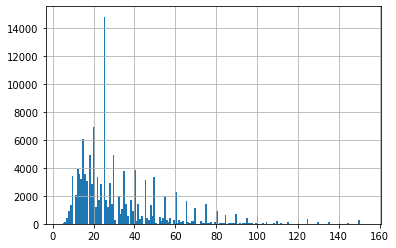

In [15]:
import numpy as np
from scipy.stats import zscore
good_rows = np.abs(zscore(df['price'].values))<=3
df[good_rows]['price'].hist(bins='auto')
df=df[good_rows]

Also, given the large numbers of different values, I will be binning my data into two bins, with the cutoff point being at 25 dollars. This will also make the classification process more efficient.

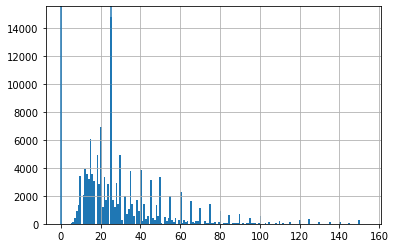

In [16]:
cut_labels = [0, 1]
cut_bins = [0,25,np.inf]
ax = df['price'].hist(bins='auto')
[ax.axvline(val) for val in cut_bins]
df['price category'] = pd.cut(df['price'], bins=cut_bins, labels=cut_labels)

In [17]:
df['price category'].value_counts(normalize=True)

0    0.545806
1    0.454194
Name: price category, dtype: float64

# Text preprocessing for modeling

In [18]:
import numpy as np
np.random.seed(0)
from nltk import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
import string

> This function will create the data in such a way that it can be used during the modeling steps.

In [19]:
def clean_description(corpus):
    """This function will be used to clean up df['description'] so that it can be used for modeling and
    visualization.
    
    Parameters:
    
    corpus - body of text that needs to be cleaned."""
    
    #Creates an extensive stopwords list
    stopwords_list = stopwords.words('english')
    additional_punc = ['“','”','...','``',"''",'’',"'s", ' ', "n't",'wine','flavor', 'flavors']
    stopwords_list+=string.punctuation
    stopwords_list.extend(additional_punc)
    
    #Tokenizes the words in the corpus
    tokens = word_tokenize(corpus)
    
    #Uses list comprehension to create the list of clean words
    clean_words = [word.lower() for word in tokens if word.lower() not in stopwords_list]
    return clean_words

In [20]:
df['clean description'] = df['description'].apply(clean_description)

In [21]:
#Verify that the function was applied correctly
df['clean description'][0]

['aromas',
 'include',
 'tropical',
 'fruit',
 'broom',
 'brimstone',
 'dried',
 'herb',
 'palate',
 'overly',
 'expressive',
 'offering',
 'unripened',
 'apple',
 'citrus',
 'dried',
 'sage',
 'alongside',
 'brisk',
 'acidity']

# Modeling: Neural Network

In [22]:
target = df['price category']

In [23]:
total_vocabulary = df['clean description']

In [24]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 128749 unique tokens in the dataset.


In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/acusiobivona/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/acusiobivona/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/acusiobivona/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

In [26]:
y = to_categorical(target).copy()
X = total_vocabulary.copy()

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [28]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_tr = sequence.pad_sequences(X_train_seq, maxlen=100)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_te = sequence.pad_sequences(X_test_seq, maxlen=100)

In [29]:
#Created so that if validation accuracy does not improve after 2 epochs, the neural network will stop running.
#This allows for more efficiency and less memory usage.
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_acc', patience=2)

In [30]:
embedding_size = 128
model = Sequential()
model.add(Embedding(20000, embedding_size)) 
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total para

In [31]:
model_1 = model.fit(X_tr, y_train, epochs=5, batch_size=256, validation_split=0.25, callbacks=[callback])

Train on 72420 samples, validate on 24141 samples
Epoch 1/5
72420/72420 [==============================] - 46s 636us/step - loss: 0.5751 - acc: 0.6964 - val_loss: 0.4906 - val_acc: 0.7606
Epoch 2/5
72420/72420 [==============================] - 45s 619us/step - loss: 0.4738 - acc: 0.7841 - val_loss: 0.4896 - val_acc: 0.7609
Epoch 3/5
72420/72420 [==============================] - 46s 641us/step - loss: 0.4267 - acc: 0.8065 - val_loss: 0.5045 - val_acc: 0.7569
Epoch 4/5
72420/72420 [==============================] - 48s 660us/step - loss: 0.3877 - acc: 0.8264 - val_loss: 0.5260 - val_acc: 0.7623
Epoch 5/5
72420/72420 [==============================] - 46s 638us/step - loss: 0.3522 - acc: 0.8450 - val_loss: 0.5668 - val_acc: 0.7582


In [32]:
y_hat_test = model.predict(X_te)
y_hat_test

array([[0.21202105, 0.9614685 ],
       [0.36852294, 0.77205086],
       [0.26606086, 0.87020785],
       ...,
       [0.00421688, 0.999998  ],
       [0.9421987 , 0.05555815],
       [0.4853678 , 0.5467239 ]], dtype=float32)

In [33]:
#Takes the above step and makes it so that we can see how the neural network predicted the classification of
#each value in the test set.
y_hat_test = y_hat_test.argmax(axis=1)
y_hat_test

array([1, 1, 1, ..., 1, 0, 1])

In [34]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(conf_matrix, classes = None, normalize=True,
                          title='Confusion Matrix', cmap="Blues",
                          print_raw_matrix=False,
                          fig_size=(4,4)):
    """
    Function code borrowed with permission from
    https://github.com/jirvingphd/fsds_pt_100719_cohort_notes/blob/master/sect_42_tuning_neural_networks-Full_SG.ipynb
    
    Check if Normalization Option is Set to True. 
    If so, normalize the raw confusion matrix before visualizing
    #Other code should be equivalent to your previous function.
    Note: Taken from bs_ds and modified
    - Can pass a tuple of (y_true,y_pred) instead of conf matrix.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.metrics as metrics
    
    ## make confusion matrix if given tuple of y_true,y_pred
    if isinstance(conf_matrix, tuple):
        y_true = conf_matrix[0].copy()
        y_pred = conf_matrix[1].copy()
        
        if y_true.ndim>1:
            y_true = y_true.argmax(axis=1)
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)
            
            
        cm = metrics.confusion_matrix(y_true,y_pred)
    else:
        cm = conf_matrix
        
    ## Generate integer labels for classes
    if classes is None:
        classes = list(range(len(cm)))  
        
    ## Normalize data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt='.2f'
    else:
        fmt= 'd'
        
        
    fontDict = {
        'title':{
            'fontsize':16,
            'fontweight':'semibold',
            'ha':'center',
            },
        'xlabel':{
            'fontsize':14,
            'fontweight':'normal',
            },
        'ylabel':{
            'fontsize':14,
            'fontweight':'normal',
            },
        'xtick_labels':{
            'fontsize':10,
            'fontweight':'normal',
    #             'rotation':45,
            'ha':'right',
            },
        'ytick_labels':{
            'fontsize':10,
            'fontweight':'normal',
            'rotation':0,
            'ha':'right',
            },
        'data_labels':{
            'ha':'center',
            'fontweight':'semibold',

        }
    }

    # Create plot
    fig,ax = plt.subplots(figsize=fig_size)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,**fontDict['title'])
    plt.colorbar()

    tick_marks = classes#np.arange(len(classes))

    plt.xticks(tick_marks, classes, **fontDict['xtick_labels'])
    plt.yticks(tick_marks, classes,**fontDict['ytick_labels'])

    # Determine threshold for b/w text
    thresh = cm.max() / 2.

    # fig,ax = plt.subplots()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 color='darkgray',**fontDict['data_labels']) #color="white" if cm[i, j] > thresh else "black"

    plt.tight_layout()
    plt.ylabel('True label',**fontDict['ylabel'])
    plt.xlabel('Predicted label',**fontDict['xlabel'])

    if print_raw_matrix:
        print_title = 'Raw Confusion Matrix Counts:'
        print('\n',print_title)
        print(conf_matrix)


    fig = plt.gcf()
    return fig



def plot_keras_history(history,figsize_1=(6,4),
    figsize_2=(8,6)):
    """Plots keras history and returns fig"""
    
    ## Make a df from history
    if isinstance(history,dict)==False:
        history=history.history
    plot_df = pd.DataFrame(history)
    plot_df['Epoch'] = range(1,len(plot_df)+1)
    plot_df.set_index('Epoch',inplace=True)
    ## Get cols for acc vs loss
    acc_cols = list(filter(lambda x: 'acc' in x, plot_df.columns))
    loss_cols = list(filter(lambda x: 'loss' in x, plot_df.columns))   
    
    ## Set figsizes based on number of keys
    if len(acc_cols)>1:
        figsize=figsize_2
    else:
        figsize=figsize_1

    ## Make figure and axes
    fig,ax = plt.subplots(nrows=2,figsize=figsize,sharex=True)
    
    ## Plot Accuracy cols in plot 1
    plot_df[acc_cols].plot(ax=ax[0])
    ax[0].set(ylabel='Accuracy')
    ax[0].set_title('Training Results')

    ## Plot loss cols in plot 2
    plot_df[loss_cols].plot(ax=ax[1])
    ax[1].set(ylabel='Loss')
    ax[1].set_xlabel('Epoch #')


#     ## Change xaxis locators 
#     [a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(len(plot_df),integer=True)) for a in ax]
#     [a.set_xlim((1,len(plot_df)+1)) for a in ax]
    plt.tight_layout()
    
    return fig

In [35]:
def evaluate_model(y_true, y_pred,history=None):
    """
    Function code borrowed with permission from
    https://github.com/jirvingphd/fsds_pt_100719_cohort_notes/blob/master/sect_39_NLP_finding_trump_SG.ipynb
    
    Evaluates neural network using sklearn metrics"""
    from sklearn import metrics
    if y_true.ndim>1:
        y_true = y_true.argmax(axis=1)
    if y_pred.ndim>1:
        y_pred = y_pred.argmax(axis=1)   
#     try:    
    if history is not None:
        plot_keras_history(history)
        plt.show()
#     except:
#         pass
    
    num_dashes=20
    print('\n')
    print('---'*num_dashes)
    print('\tCLASSIFICATION REPORT:')
    print('---'*num_dashes)
    try:
        print(metrics.classification_report(y_true,y_pred))
        
        fig = plot_confusion_matrix((y_true,y_pred))
        plt.show()
    except Exception as e:
        print(f"[!] Error during model evaluation:\n\t{e}")



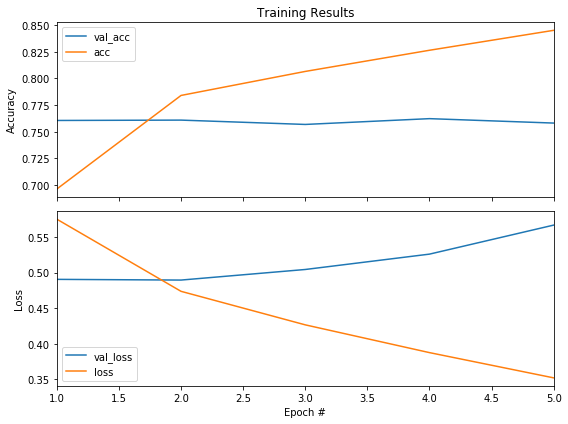



------------------------------------------------------------
	CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     17568
           1       0.73      0.72      0.73     14620

    accuracy                           0.75     32188
   macro avg       0.75      0.75      0.75     32188
weighted avg       0.75      0.75      0.75     32188



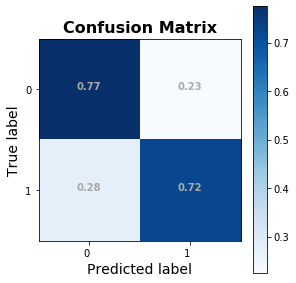

In [36]:
evaluate_model(y_test, y_hat_test, model_1)

## Evaluation: The neural network was able to correctly classify the cheap wine bottles (0) 77% percent of the time and correctly identified the expensive wine bottles (1) 72% of the time. We also can see from the keras history graphs that the point of convergence did not occur too soon, despite the neural network only needing 3 epochs to process everything. Overall, I got a 75% testing accuracy, which I believe can be further improved with continued tuning.

# Modeling: Random Forest

> The question may be asked, why is a random forest being used when a neural network has already been performed for the purpose of prediction? The reason is neural networks, with all their power, are very challenging in providing meaningful insights into what their results mean, aside from a classification report. I'm running the random forest to get insights into both which words were used and the frequency of those words when making predictions. 

In [37]:
y = df['price category'].copy()
X = df['description'].copy()

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

Confirm that data in train and test group is divided similarly

In [39]:
y_train.value_counts(normalize=True)

0    0.54581
1    0.45419
Name: price category, dtype: float64

In [40]:
y_test.value_counts(normalize=True)

0    0.545793
1    0.454207
Name: price category, dtype: float64

The text data must be vectorized so that it can be usable data in this machine learning process.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_list = stopwords.words('english')
additional_punc = ['“','”','...','``',"''",'’',"'s", 'wine', 'flavor', 'flavors']
stopwords_list+=string.punctuation
stopwords_list.extend(additional_punc)
vectorizer = TfidfVectorizer(stop_words=stopwords_list)

In [42]:
tf_idf_train = vectorizer.fit_transform(X_train)
tf_idf_test = vectorizer.transform(X_test)

I used GridSearch in order to find the optimal hyperparameters for my random forest. The results of the gridsearch are displayed in line 15-20 in the cell below. The code was as follows:

    from sklearn.model_selection import GridSearchCV
    params  = {'criterion':['gini','entropy'],
          'max_depth':[3,5,10,50,100,None],
          'class_weight':['balanced',None],
           'bootstrap':[True ,False],
          'min_samples_leaf':[1,2,3,4],}
          
    rf_clf = RandomForestClassifier()
    grid = GridSearchCV(rf_clf,params,return_train_score=False, scoring='recall_weighted',n_jobs=-1)
    
    grid.fit(tf_idf_train,y_train)
    print(grid.best_score_)
    grid.best_params_

    Gridsearch Results
    {'bootstrap': False,
     'class_weight': None,
     'criterion': 'entropy',
     'max_depth': None,
     'min_samples_leaf': 1}

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(criterion='entropy', bootstrap=False)
rf_clf.fit(tf_idf_train, y_train)
y_hat_train = rf_clf.predict(tf_idf_train)
y_hat_test = rf_clf.predict(tf_idf_test)

In [44]:
from sklearn import metrics

def evaluate_model(y_test,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score,verbose=False):
    
    """This function will create and return a classification report and confusion matrix.
    
    Function code borrowed with permsission from
    https://github.com/jirvingphd/fsds_pt_100719_cohort_notes/blob/master/sect_39_NLP_finding_trump_SG.ipynb
    
    Parameters:
    
    y_test - The y testing data
    
    y_hat_test - The y prediction data
    
    X_test - The X testing data
    
    clf - Name of your model
    """

    print(metrics.classification_report(y_test,y_hat_test))
    metrics.plot_confusion_matrix(clf,X_test,y_test,normalize='true',
                                 cmap='Blues')
    plt.show()
    if verbose:
        print("MODEL PARAMETERS:")
        print(pd.Series(rf.get_params()))
        

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     17568
           1       0.78      0.70      0.74     14620

    accuracy                           0.78     32188
   macro avg       0.78      0.77      0.77     32188
weighted avg       0.78      0.78      0.78     32188



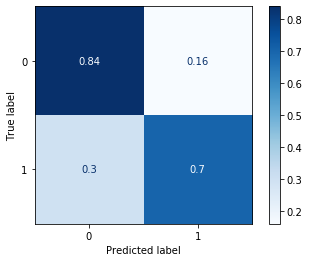

In [45]:
evaluate_model(y_test, y_hat_test, tf_idf_test, rf_clf)

> Below I will discover the most important overall words for the model. This is a key insight for any recommendations.

In [46]:
vectorizer.get_feature_names()[:10]

['000', '008', '01', '02', '03', '030', '035', '04', '05', '056']

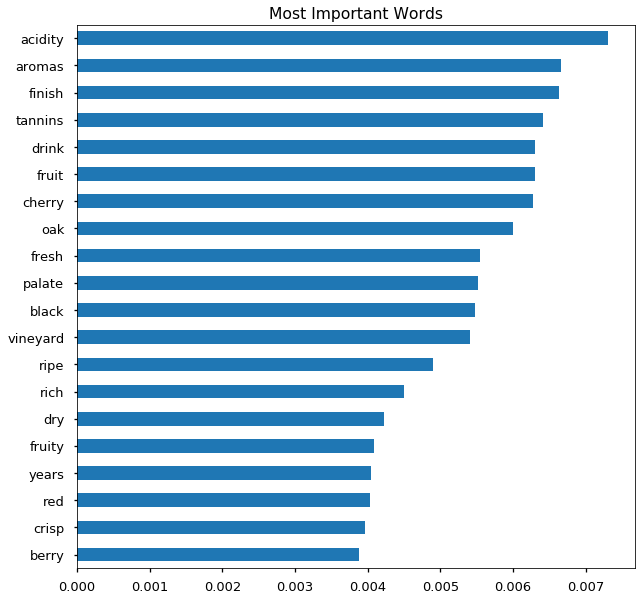

In [47]:
with plt.style.context('seaborn-talk'):

    importance = pd.Series(rf_clf.feature_importances_,vectorizer.get_feature_names())
    importance.sort_values().tail(20).plot(kind='barh',figsize=(10,10))
    plt.title('Most Important Words')

## Evaluation: In terms of classifying, we got an interesting result in that the random forest was better at predicting the classification of the cheaper bottles of wine than the neural network, but was quite a bit worse at classifying the expensive bottles. But, the real value of this model is in the graph above, where we can see which words were the most important when trying to classify each wine bottle. An important note, however, is that the graph above does not specify which words belong to which class.

# Create Meaningful Visuals

### Create frequency distributions for whole dataset and for each class

**Whole dataset**

In [80]:
corpus = df['description']
','.join(corpus)
tokens = word_tokenize(','.join(corpus))
stopwords_list = stopwords.words('english')
additional_punc = ['“','”','...','``',"''",'’',"'s", ' ', "n't",'wine','flavor', 'flavors']
stopwords_list+=string.punctuation
stopwords_list.extend(additional_punc)
stopped_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_list]
freq = FreqDist(stopped_tokens)
freq.most_common(20)

[('fruit', 43391),
 ('aromas', 39242),
 ('palate', 37094),
 ('acidity', 31404),
 ('tannins', 27567),
 ('drink', 27364),
 ('cherry', 26978),
 ('ripe', 26578),
 ('black', 24934),
 ('finish', 21879),
 ('red', 18555),
 ('notes', 18256),
 ('spice', 17922),
 ('rich', 16896),
 ('nose', 16801),
 ('fresh', 16593),
 ('oak', 15655),
 ('berry', 15282),
 ('dry', 15010),
 ('plum', 13935)]

**Cheap Wine**

In [82]:
df2 = df.loc[df['price category'] == 0]
df2

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price category,clean description
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,25.0,Sicily & Sardinia,Etna,N/A,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,0,"[aromas, include, tropical, fruit, broom, brim..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,N/A,N/A,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0,"[ripe, fruity, smooth, still, structured, firm..."
2,US,"Tart and snappy, the flavors of lime flesh and...",N/A,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,0,"[tart, snappy, lime, flesh, rind, dominate, gr..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,N/A,Alexander Peartree,N/A,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,0,"[pineapple, rind, lemon, pith, orange, blossom..."
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,N/A,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,0,"[blackberry, raspberry, aromas, show, typical,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129956,New Zealand,"The blend is 44% Merlot, 33% Cabernet Sauvigno...",Gimblett Gravels Merlot-Cabernet Sauvignon-Malbec,90,19.0,Hawke's Bay,N/A,N/A,Joe Czerwinski,@JoeCz,Esk Valley 2011 Gimblett Gravels Merlot-Cabern...,Bordeaux-style Red Blend,Esk Valley,0,"[blend, 44, merlot, 33, cabernet, sauvignon, 2..."
129957,Spain,Lightly baked berry aromas vie for attention w...,Crianza,90,17.0,Northern Spain,Rioja,N/A,Michael Schachner,@wineschach,Viñedos Real Rubio 2010 Crianza (Rioja),Tempranillo Blend,Viñedos Real Rubio,0,"[lightly, baked, berry, aromas, vie, attention..."
129963,Israel,"A bouquet of black cherry, tart cranberry and ...",Oak Aged,90,20.0,Galilee,N/A,N/A,Mike DeSimone,@worldwineguys,Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee),Cabernet Sauvignon,Dalton,0,"[bouquet, black, cherry, tart, cranberry, clov..."
129964,France,"Initially quite muted, this wine slowly develo...",Domaine Saint-Rémy Herrenweg,90,25.0,Alsace,Alsace,N/A,Roger Voss,@vossroger,Domaine Ehrhart 2013 Domaine Saint-Rémy Herren...,Gewürztraminer,Domaine Ehrhart,0,"[initially, quite, muted, slowly, develops, im..."


In [83]:
corpus = df2['description']
','.join(corpus)
tokens = word_tokenize(','.join(corpus))
stopwords_list = stopwords.words('english')
additional_punc = ['“','”','...','``',"''",'’',"'s", ' ', "n't",'wine','flavor', 'flavors']
stopwords_list+=string.punctuation
stopwords_list.extend(additional_punc)
stopped_tokens_0 = [word.lower() for word in tokens if word.lower() not in stopwords_list]
freq = FreqDist(stopped_tokens_0)
freq.most_common(20)

[('aromas', 22594),
 ('fruit', 22319),
 ('palate', 19588),
 ('acidity', 18595),
 ('ripe', 14005),
 ('drink', 13616),
 ('finish', 12581),
 ('tannins', 12177),
 ('cherry', 11441),
 ('fresh', 11314),
 ('black', 9730),
 ('notes', 9663),
 ('red', 9650),
 ('berry', 8993),
 ('crisp', 8810),
 ('dry', 8807),
 ('nose', 8793),
 ('spice', 8692),
 ('apple', 8513),
 ('fruits', 8149)]

**Expensive wine**

In [85]:
df3 = df.loc[df['price category'] == 1]
df3

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price category,clean description
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,1,"[much, like, regular, bottling, 2012, comes, a..."
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,N/A,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,1,"[great, depth, fresh, apple, pear, fruits, tou..."
11,France,"This is a dry wine, very spicy, with a tight, ...",N/A,87,30.0,Alsace,Alsace,N/A,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer,1,"[dry, spicy, tight, taut, texture, strongly, m..."
12,US,"Slightly reduced, this wine offers a chalky, t...",N/A,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini,1,"[slightly, reduced, offers, chalky, tannic, ba..."
16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,N/A,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque,1,"[baked, plum, molasses, balsamic, vinegar, che..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,N/A,Roger Voss,@vossroger,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,1,"[rich, beautiful, dry, also, offers, considera..."
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,N/A,N/A,Anna Lee C. Iijima,N/A,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),1,"[notes, honeysuckle, cantaloupe, sweeten, deli..."
129967,US,Citation is given as much as a decade of bottl...,N/A,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,1,"[citation, given, much, decade, bottle, age, p..."
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,N/A,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,1,"[well-drained, gravel, soil, gives, crisp, dry..."


In [86]:
corpus = df3['description']
','.join(corpus)
tokens = word_tokenize(','.join(corpus))
stopwords_list = stopwords.words('english')
additional_punc = ['“','”','...','``',"''",'’',"'s", ' ', "n't",'wine','flavor', 'flavors']
stopwords_list+=string.punctuation
stopwords_list.extend(additional_punc)
stopped_tokens_1 = [word.lower() for word in tokens if word.lower() not in stopwords_list]
freq = FreqDist(stopped_tokens_1)
freq.most_common(20)

[('fruit', 21072),
 ('palate', 17506),
 ('aromas', 16648),
 ('cherry', 15537),
 ('tannins', 15390),
 ('black', 15204),
 ('drink', 13748),
 ('acidity', 12809),
 ('ripe', 12573),
 ('oak', 9818),
 ('rich', 9394),
 ('finish', 9298),
 ('spice', 9230),
 ('red', 8905),
 ('notes', 8593),
 ('nose', 8008),
 ('blackberry', 7334),
 ('cabernet', 6860),
 ('dark', 6822),
 ('blend', 6469)]

### Create Wordclouds & Bigrams

> I created two functions that will generate wordclouds and bigrams that can be used to make for the whole dataset and for each classification.

In [55]:
from wordcloud import WordCloud
def create_wordcloud(tokens):
    """
    Create a WordCloud
    
    Parameters:
    
    tokens - Some form of tokenized text data
    
    """
    
    wordcloud = WordCloud(stopwords='stopwords_list', collocations=False, max_words=40)
    wordcloud.generate(','.join(tokens))
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis('off')

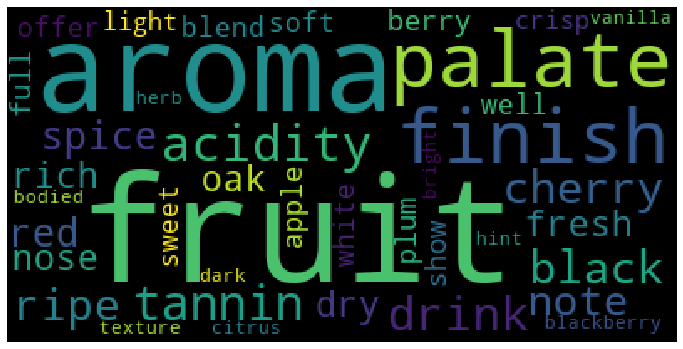

In [66]:
create_wordcloud(stopped_tokens)

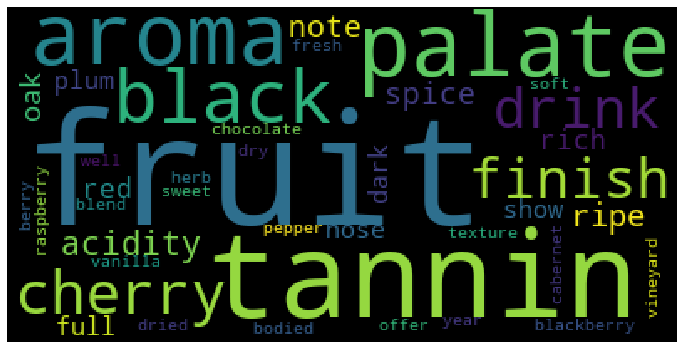

In [67]:
create_wordcloud(stopped_tokens_0)

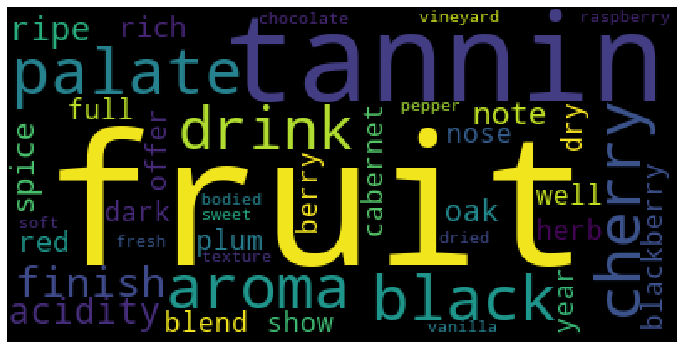

In [68]:
create_wordcloud(stopped_tokens_1)

In [76]:
import nltk
def create_bigram(token_data):
    """
    Create a Bigram
    
    Parameters:
    
    tokens - tokenized data
    
    """
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    word_finder = nltk.BigramCollocationFinder.from_words(token_data)

    words_scored = word_finder.score_ngrams(bigram_measures.raw_freq)
    top_words = pd.DataFrame.from_records(words_scored,columns=['Words','Frequency']).head(20)
    return top_words

In [81]:
create_bigram(stopped_tokens).style.hide_index().set_caption('All Reviews')

Words,Frequency
"('black', 'cherry')",0.00237452
"('drink', 'now.')",0.00186115
"('cabernet', 'sauvignon')",0.00158051
"('palate', 'offers')",0.00137223
"('pinot', 'noir')",0.000983706
"('black', 'pepper')",0.000848764
"('white', 'pepper')",0.000792376
"('black', 'currant')",0.000781619
"('nose', 'palate')",0.000757499
"('finish', 'drink')",0.000749677


In [84]:
create_bigram(stopped_tokens_0).style.hide_index().set_caption('Cheap Wine Reviews')

Words,Frequency
"('drink', 'now.')",0.00258455
"('black', 'cherry')",0.00175851
"('palate', 'offers')",0.00136917
"('cabernet', 'sauvignon')",0.00103953
"('sauvignon', 'blanc')",0.000949335
"('ready', 'drink')",0.000945441
"('green', 'apple')",0.000941548
"('ready', 'drink.')",0.000891583
"('stone', 'fruit')",0.000837076
"('red', 'berry')",0.00082864


In [87]:
create_bigram(stopped_tokens_1).style.hide_index().set_caption('Expensive Wine Reviews')

Words,Frequency
"('black', 'cherry')",0.00299625
"('cabernet', 'sauvignon')",0.00212652
"('palate', 'offers')",0.00137533
"('pinot', 'noir')",0.00125744
"('black', 'pepper')",0.00120177
"('drink', 'now.')",0.00113104
"('cabernet', 'franc')",0.00107275
"('petit', 'verdot')",0.000899201
"('white', 'pepper')",0.000873004
"('black', 'currant')",0.000850737


In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return 0
    

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
wine_mask = np.array(Image.open(path.join(d,'wine glass mask.png')))


transformed_wine_mask = wine_mask#np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)


for i in range(len(wine_mask)):
    transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))
    

In [ ]:
transformed_wine_mask
plt.imshow(transformed_wine_mask, cmap='gray')

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
wine_mask = np.array(Image.open(path.join(d,'wine glass mask.png')))
wc = WordCloud(background_color='white', stopwords='stopwords_list', collocations=False, mask=transformed_wine_mask,
               contour_color='steelblue')
wc.generate(','.join(stopped_tokens))
wc.to_file(path.join(d, 'wine.png'))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Recommendations

> Wineries can take these words and use them to create unique scents, aromas, and tastes in either their pre-existing products or any new ones they may create. They can also boost their products they already have in their marketing knowing that there are specific words that are unqiue to the price point of certain bottles of wine. Words from expensive wines can be used to make cheaper wines seem more valuable, along with words from cheaper wines can be used to make expensive wines more appealing or reach a wider audience.

# Conclusion

> I was able to successfully classify our wine data by its two groups, cheap or expensive, with 77% of the cheap wine being correctly classified and 72% of the expensive wine being correctly classified, while having an overall testing accuarcy of 75%. I was also able to identify that each group contains unique keywords, such as "fresh, berry, & crisp" for the cheap wines, and "oak, rich, & blackberry" for the expensive wines. I believe that these results can provide a lot of unique insight to wineries, especially considering that these unique results came from the thoughts of professional wine reviewers.